### 라이브러리

In [1]:
import ast
import nltk
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator

### 감성 분석 시각화 함수

In [2]:
sentiment_df = pd.read_csv('./queen_sentiment.csv', lineterminator='\n', encoding='utf-8-sig')

def visualize_sentiment_analysis(df, n, filename):
    # 데이터프레임 복사 후 인덱스를 id로 변경
    copied = sentiment_df.copy(deep=True)
    copied = copied.set_index(keys='id')
    
    # 입력된 데이터프레임의 id 반환
    id_lst = list(df['id'])
    
    # 감성 분석 결과 저장
    copied = copied.loc[id_lst]
    all_tweet = list(copied['tweet'])
    all_sentiment = list(copied['sentiment\r'])
    
    # 감성 분석 결과 수치화
    all_sentiment = [ast.literal_eval(s) for s in all_sentiment]
    for s in all_sentiment: s.sort(key=lambda x: x[0], reverse=True)
    sentiment_score = [s[0][0] for s in all_sentiment]
    sentiment_label = [s[0][1] for s in all_sentiment]
    
    
    # 감성 분석 레이블 분포 시각화
    def label2num(text):
        if text == 'Positive': return 1
        elif text == 'Negative': return 0
        else: return 2
    sentiment_label = [label2num(l) for l in sentiment_label]

    labels = ['Positive', 'Negative', 'Neutral']
    values = [sentiment_label.count(1), sentiment_label.count(0), sentiment_label.count(2)]
    plt.figure(figsize=(4, 4))
    plt.pie(values, autopct='%.2f%%', colors=['skyblue', 'red', 'lightgreen'])
    plt.legend(labels)
    plt.savefig(f'./visualization/queen_sa_pie_{filename}.png')
    
    
    # 감성 분석 스코어가 높은 트윗 출력
    def pair2score_sorted(pair, labelnum, n):
        pair = [p if p[1] == labelnum else None for p in pair]
        while None in pair: pair.remove(None)
        pair = [p if type(p[0]) == float else None for p in pair]
        while None in pair: pair.remove(None)
        pair.sort(key=lambda x: x[0], reverse=True)
        return pair[:n]
    pair = [[sentiment_score[i], sentiment_label[i], i] for i in range(len(sentiment_score))]
    pos_pair = pair2score_sorted(pair, 1, n) 
    neg_pair = pair2score_sorted(pair, 0, n)
    neu_pair = pair2score_sorted(pair, 2, n)
    
    def pair2lst(all_tweet, pair):
        score_lst = [p[0] for p in pair]
        index_lst = [p[2] for p in pair]
        tweet_lst = [all_tweet[idx] for idx in index_lst]
        return tweet_lst, score_lst
    pos_tweet, pos_score = pair2lst(all_tweet, pos_pair)
    neg_tweet, neg_score = pair2lst(all_tweet, neg_pair)
    neu_tweet, neu_score = pair2lst(all_tweet, neu_pair)
    df = pd.DataFrame({f'긍정 상위 {n}개 트윗': pos_tweet, '긍정 점수': pos_score,
                       f'부정 상위 {n}개 트윗': neg_tweet, '부정 점수': neg_score,
                       f'중립 상위 {n}개 트윗': neu_tweet, '중립 점수': neu_score})
    df.to_csv(f'./visualization/queen_sa_df_{filename}.csv', index=False, encoding='utf-8-sig')

### 워드클라우드 생성 함수

In [3]:
def text2wordscount(df, threshold):
    # 특수문자 제거
    df['tweet'] = df['tweet'].str.replace('[^a-zA-Z]', ' ')
    # 2글자 이하 제거
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) >= 3]))
    # 소문자로 변환
    df['tweet'] = df['tweet'].apply(lambda x: x.lower())
    # 여왕 지칭 단어 제거
    df['tweet'] = df['tweet'].str.replace('queen', '')
    df['tweet'] = df['tweet'].str.replace('elizabeth', '')
    df['tweet'] = df['tweet'].str.replace('ii', '')

    # 불용어 처리 및 토큰화
    stop_words = nltk.corpus.stopwords.words('english')
    tokenized_tweet = df['tweet'].apply(lambda x: x.split())
    tokenized_tweet = tokenized_tweet.apply(lambda x: [item for item in x if item not in stop_words])
    
    # 토큰들 단일 리스트화
    merged = [token for sublst in tokenized_tweet for token in sublst]
    
    # 단어 등장 횟수 딕셔너리화
    count = Counter(merged)
    wordscount = dict(count.most_common())
    
    # threshold번 이상 등장한 단어들 제거
    if threshold != None:
        items = list(wordscount.items())
        items = [item if item[1] < threshold else None for item in items]
        while None in items: items.remove(None)
        wordscount = dict((x, y) for x, y in items)
    return wordscount

In [4]:
def visualize_wordcloud(df, threshold, color, filename):
    wordscount = text2wordscount(df, threshold)
    
    if color == 'purple':
        mask = np.array(Image.open('./visualization/purple_rectangle.png'))
    elif color == 'red':
        mask = np.array(Image.open('./visualization/red_rectangle.png'))
    elif color == 'brown':
        mask = np.array(Image.open('./visualization/brown_rectangle.png'))
    
    image_colors = ImageColorGenerator(mask)
    wordcloud = WordCloud(background_color='white',
                          mask=mask,
                          width=mask.shape[1],
                          height=mask.shape[0],
                          prefer_horizontal=0.99999)
    cloud = wordcloud.generate_from_frequencies(wordscount)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(cloud.recolor(color_func=image_colors), interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f'./visualization/queen_wc_{filename}.png')

### 트윗 시간순 시각화: 감성 분석

In [5]:
hour_path = './condition/hour/queen_'

df_hour_0    = pd.read_csv(hour_path+'hour_0.csv', lineterminator='\n', encoding='utf-8-sig')
df_hour_1to2 = pd.read_csv(hour_path+'hour_1to2.csv', lineterminator='\n', encoding='utf-8-sig')
df_hour_3to5 = pd.read_csv(hour_path+'hour_3to5.csv', lineterminator='\n', encoding='utf-8-sig')
df_hour_6to9 = pd.read_csv(hour_path+'hour_6to9.csv', lineterminator='\n', encoding='utf-8-sig')

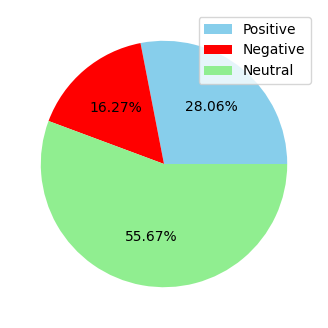

In [6]:
visualize_sentiment_analysis(df=df_hour_0, n=5, filename='hour_0')

In [7]:
df = pd.read_csv('./visualization/queen_sa_df_hour_0.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  Thank you so much Ulli for your beautiful word...  0.990939   
1  R.I.P our lovely Queen ♥️ My favourite pic of ...  0.990256   
2  I'm excited for the Queen Elizabeth II Fortnit...  0.990071   
3  It turned out to be her final public picture f...  0.989765   
4  Queen Elizabeth II 👑❤️ What a woman, I am so g...  0.989729   

                                         부정 상위 5개 트윗     부정 점수  \
0  RIP Queen Elizabeth II 💔 Some people are so di...  0.977804   
1  Today has been a shitty day…. I am in-between ...  0.977518   
2  Queen Elizabeth II was a horrible person that ...  0.977315   
3  FUCK YOU QUEEN ELIZABETH II, THIS IS WHAT I TH...  0.976610   
4  If Queen Elizabeth II died in a New York nursi...  0.975660   

                                         중립 상위 5개 트윗     중립 점수  
0  The Queen Elizabeth II here seen before leavin...  0.958858  
1  1961 :: Queen Elizabeth II Addressing Mammoth ...  0.948466  
2  Via   Oct. 1957: Queen Elizabeth II with UMD P...  0.948000  
3  Check out Queen Elizabeth II-1980s Windsor Cas...  0.945812  
4  West Virginia Senator Joe Manchin met Queen El...  0.944040

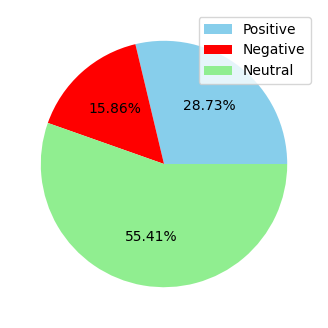

In [8]:
visualize_sentiment_analysis(df=df_hour_1to2, n=5, filename='hour_1to2')

In [9]:
df = pd.read_csv('./visualization/queen_sa_df_hour_1to2.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  This has &amp; will always be my favourite pic...  0.992326   
1  You have been a great role model, much loved r...  0.991891   
2  Love this artwork with the great Queen Elizabe...  0.991820   
3  This was probably my favourite part of the Jub...  0.991582   
4  This is absolutely wonderful. Her amazing sens...  0.991316   

                                         부정 상위 5개 트윗     부정 점수  \
0  Today showed how disgusting people can be. I'm...  0.980233   
1  The death of our longest serving Monarch has r...  0.980029   
2  I have lost any respect I had for  because of ...  0.979341   
3  What the hell am I reading 😮 😳   Some sick peo...  0.979314   
4  Hatred is like drinking poison and expecting t...  0.978343   

                                         중립 상위 5개 트윗     중립 점수  
0  Sen. Mitch McConnell issued a statement on the...  0.954100  
1  3 bedroom house available for sale at Communit...  0.952274  
2  Queen Elizabeth II and Prince Philip pose with...  0.951922  
3  Meet the Muslim princess Zaida Spanish ancesto...  0.948897  
4  Do Harry and Meghan now become the Duke and Du...  0.948851

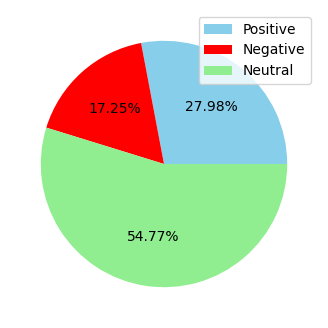

In [10]:
visualize_sentiment_analysis(df=df_hour_3to5, n=5, filename='hour_3to5')

In [11]:
df = pd.read_csv('./visualization/queen_sa_df_hour_3to5.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  Have a great evening my friend.  Saw the news ...  0.992726   
1  Her Majesty The Queen, Elizabeth II. I love yo...  0.992353   
2  Ok, this just made my eyes well up again but a...  0.992285   
3  R.I.P.  96 years of a wonderful life and 70 ye...  0.992001   
4  This may be one of my favorite photos of Queen...  0.991685   

                                         부정 상위 5개 트윗     부정 점수  \
0  And my third, and maybe final tweet on this, b...  0.980179   
1  is being and insensitive bitch with this tweet...  0.979810   
2  1974 45774476  100%!!! This is disgusting!!! "...  0.979739   
3  Dude it’s not fucking cool when you make  or s...  0.979262   
4  I'm seriously appalled at how evil and bloody ...  0.978959   

                                         중립 상위 5개 트윗     중립 점수  
0  Which musician in Ghana do u think will do a s...  0.954906  
1  KIRO 7 News - Queen Elizabeth II visits Seattl...  0.951721  
2  KIRO 7 News - Queen Elizabeth II visits Seattl...  0.951721  
3  10 days state visit to  in March 1961, Tehran,...  0.948792  
4  Do you guys think Chris Chan is going to write...  0.948741

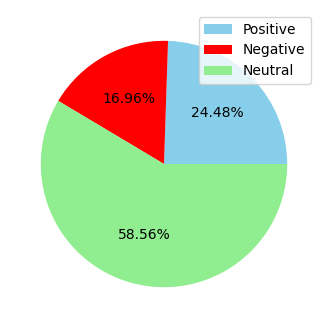

In [12]:
visualize_sentiment_analysis(df=df_hour_6to9, n=5, filename='hour_6to9')

In [13]:
df = pd.read_csv('./visualization/queen_sa_df_hour_6to9.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  The Irish and Argentine folks are having a bla...  0.993509   
1  Absolutely the most beautiful tribute to Queen...  0.992284   
2  I absolutely love this video 🥺 ⁦⁩ ⁦⁩ RIP Queen...  0.991547   
3  This is an AMAZING site! R.I.P. Queen Elizabet...  0.991520   
4  I am proud that I got to live in the era of Qu...  0.991229   

                                         부정 상위 5개 트윗     부정 점수  \
0  Queen Elizabeth II is so inconsiderate that sh...  0.980774   
1  Nobody fuckin' cares about the dumbass UK pedo...  0.980240   
2  Something so f**kd up about the way this gener...  0.979398   
3  You guys are a fucking headache whenever someb...  0.979073   
4  Fucking asshole kontol memek bangsat puki jemb...  0.979036   

                                         중립 상위 5개 트윗     중립 점수  
0  During her tour to the Maldives, H.M. Queen El...  0.951547  
1  Pic 1) Queen Elizabeth II with former PM Shri ...  0.950383  
2  Prime Minister of India, Indira Gandhi and Que...  0.950027  
3  1961 :: Queen Elizabeth II Addressing Mammoth ...  0.949615  
4  Pass that belonged to a member of the royal ho...  0.948061

### 트윗 시간순 시각화: 워드클라우드

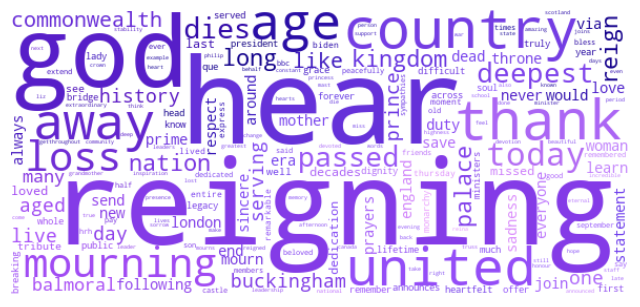

In [14]:
visualize_wordcloud(df=df_hour_0, threshold=1000, color='purple', filename='hour_0')

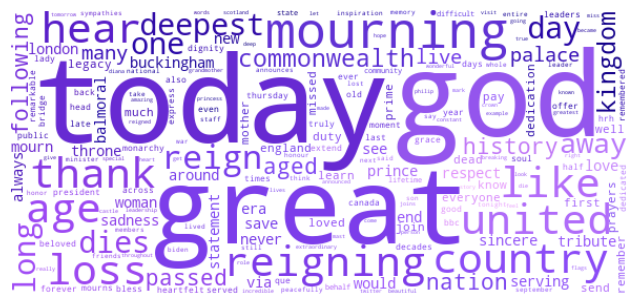

In [15]:
visualize_wordcloud(df=df_hour_1to2, threshold=1000, color='purple', filename='hour_1to2')

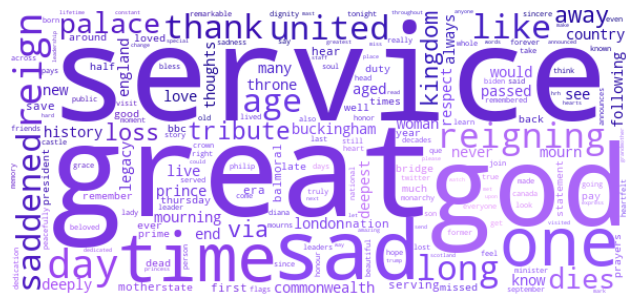

In [16]:
visualize_wordcloud(df=df_hour_3to5, threshold=1000, color='purple', filename='hour_3to5')

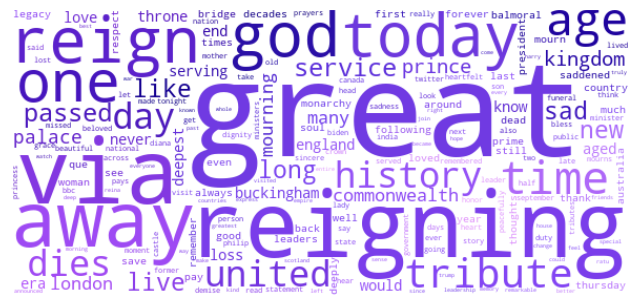

In [17]:
visualize_wordcloud(df=df_hour_6to9, threshold=1000, color='purple', filename='hour_6to9')

### 트윗 좋아요순 시각화: 감성 분석

In [18]:
like_path = './condition/likes_count/queen_'

df_like_0       = pd.read_csv(like_path+'like_0.csv', lineterminator='\n', encoding='utf-8-sig')
df_like_1to10   = pd.read_csv(like_path+'like_1to10.csv', lineterminator='\n', encoding='utf-8-sig')
df_like_11to50  = pd.read_csv(like_path+'like_11to50.csv', lineterminator='\n', encoding='utf-8-sig')
df_like_51to100 = pd.read_csv(like_path+'like_51to100.csv', lineterminator='\n', encoding='utf-8-sig')
df_like_over100 = pd.read_csv(like_path+'like_over100.csv', lineterminator='\n', encoding='utf-8-sig')

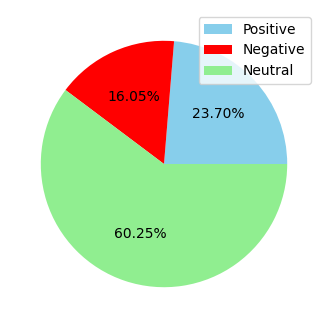

In [19]:
visualize_sentiment_analysis(df=df_like_0, n=5, filename='like_0')

In [20]:
df = pd.read_csv('./visualization/queen_sa_df_like_0.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  Happy Birthday to the Real Queen❤️ May she liv...  0.991090   
1  My loving great  🐻I never say goodbye. I alway...  0.989117   
2  I can’t wait to sing God Save the Queen at the...  0.988874   
3  A beautiful tribute &amp; piece of history abo...  0.987631   
4  Thank you Your Majesty for an incredible reign...  0.987181   

                                         부정 상위 5개 트윗     부정 점수  \
0  Having a hard time reading so many disgusting ...  0.979526   
1  1974   has NOT  seen this tweet the disrespect...  0.975282   
2  Indeed! It's astonishing to me that he's still...  0.969684   
3  An old woman died and you guys are making fun ...  0.969084   
4  What a disgusting,uneducated human. Queen Eliz...  0.967538   

                                         중립 상위 5개 트윗     중립 점수  
0  October 6, 2002: Queen Elizabeth II drops the ...  0.952633  
1  Queen Elizabeth II at the Tissisal Falls with ...  0.937660  
2  A short story from Aish [Jerusalem] about Quee...  0.936187  
3  GALLERY: Queen Elizabeth II visits to the Nort...  0.934586  
4  The new Royal Line of Succession after the pas...  0.932194

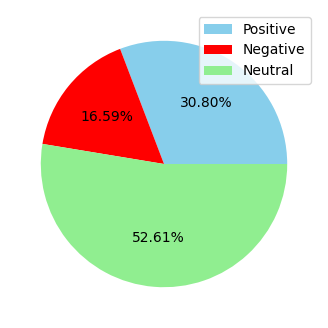

In [21]:
visualize_sentiment_analysis(df=df_like_1to10, n=5, filename='like_1to10')

In [22]:
df = pd.read_csv('./visualization/queen_sa_df_like_1to10.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  That was great ! That means a lot ! I believe ...  0.991825   
1  Thank you so much for honoring Queen Elizabeth...  0.989397   
2  Lovely words Sara ❤️ My Nanna always admired ,...  0.987126   
3  Thank you for your beautiful example ma'am. Yo...  0.987059   
4  Boris Johnson’s statement is the best thing he...  0.986273   

                                         부정 상위 5개 트윗     부정 점수  \
0  Here to remind everyone that the royal family ...  0.979034   
1  Comments from Americans on President Biden's t...  0.973879   
2  Talking about queen Elizabeth II what a terrib...  0.972309   
3  You are clearly condoning her disgusting tweet...  0.967660   
4  From how people are uttering negative messages...  0.967075   

                                         중립 상위 5개 트윗     중립 점수  
0  Queen Elizabeth II took the throne in February...  0.947376  
1  Urvashi Rautela might post this on her insta s...  0.941990  
2  ALT: Queen Elizabeth II meets Apollo 11 astron...  0.941118  
3  EXCLUSIVE: This RI Governor Dined Next to Quee...  0.940213  
4  A look back at Queen Elizabeth II’s visit to S...  0.937637

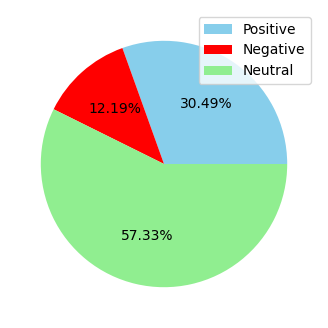

In [23]:
visualize_sentiment_analysis(df=df_like_11to50, n=5, filename='like_11to50')

In [24]:
df = pd.read_csv('./visualization/queen_sa_df_like_11to50.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  hope you're having a martini with the queen rn...  0.989589   
1  What a wonderful memory to keep forever - than...  0.988137   
2  A gorgeous morning in Looe. Reflecting on an i...  0.986979   
3  We salute the longest reigning monarch in hist...  0.986186   
4  Thank you for your selfless service to your co...  0.986037   

                                         부정 상위 5개 트윗     부정 점수  \
0  I know that I'm supposed to be on hiatus from ...  0.976606   
1  this shit get uglier than queen Elizabeth ii o...  0.969773   
2  the queen elizabeth II discourse is wild you g...  0.966558   
3  Vile, profanity! When did Queen Elizabeth II b...  0.963090   
4  Fucktard thinks I'm a right wing troll because...  0.959569   

                                         중립 상위 5개 트윗     중립 점수  
0  Front page of the Minneapolis Morning Tribune ...  0.943224  
1  Former President Mahama and wife, Lordina, met...  0.942980  
2  Remembered: ABC Reveals Its Thursday-Night Cov...  0.942720  
3  In 1965 Jack Benny met Queen Elizabeth II at t...  0.940825  
4  Prince Charles Conqueror Haki Before Becoming ...  0.939848

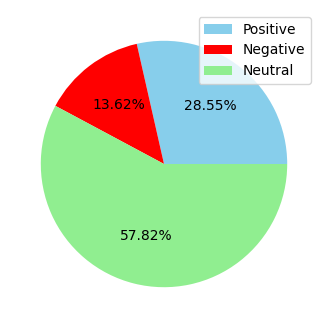

In [25]:
visualize_sentiment_analysis(df=df_like_51to100, n=5, filename='like_51to100')

In [26]:
df = pd.read_csv('./visualization/queen_sa_df_like_51to100.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  This is my favorite Queen Elizabeth II anecdot...  0.987567   
1  This is glorious. What a woman she was.  Queen...  0.986893   
2  A fantastic tribute to Her Majesty Queen Eliza...  0.984254   
3  I can never describe the love and respect I ha...  0.983861   
4  The Greatest there ever was… ❤️  Thankyou HM Q...  0.983279   

                                         부정 상위 5개 트윗     부정 점수  \
0  32021692 This is a complete insult to our Maje...  0.977918   
1  Remember that Queen Elizabeth II was an evil c...  0.968787   
2  The sleep didnt take    MY  I KNOW YOU UP THER...  0.967473   
3  I think its safe to say that today has been th...  0.965283   
4  To see such vile comments about Queen Elizabet...  0.965241   

                                         중립 상위 5개 트윗     중립 점수  
0  Queen Elizabeth II meets Saudi King Khalid upo...  0.955068  
1  :  Queen Elizabeth II drops the puck for cerem...  0.943131  
2  Friday 9th September 2022  UK national front p...  0.942946  
3  The Duchess of Cornwall's new role was defined...  0.941484  
4  The Detroit Free Press front page on Feb. 7, 1...  0.939096

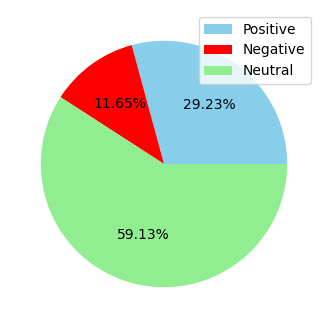

In [27]:
visualize_sentiment_analysis(df=df_like_over100, n=5, filename='like_over100')

In [28]:
df = pd.read_csv('./visualization/queen_sa_df_like_over100.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  Hands down, this is one of the best stories ab...  0.987912   
1  We are privileged to have hosted our Patron, H...  0.986281   
2  You can never get tired of hearing this story ...  0.986230   
3  Huw Edwards has been absolutely magnificent to...  0.986091   
4  Goodnight my friends. We haff missed you all a...  0.984749   

                                         부정 상위 5개 트윗     부정 점수  \
0  There is a special place in hell for those cel...  0.972255   
1  Queen Elizabeth II despised Trump.  His rude, ...  0.968527   
2  You don't twerk at someone's funeral. Let alon...  0.968332   
3  Just heard a stupid analyst on cable news say ...  0.959568   
4  Say whatever you like, but I'm bloody relieved...  0.954569   

                                         중립 상위 5개 트윗     중립 점수  
0  1961 :: Queen Elizabeth II Addressing Mammoth ...  0.948466  
1  Queen Elizabeth II is pictured with the Govern...  0.947951  
2  PBBM STATEMENT ON THE PASSING OF QUEEN ELIZABE...  0.945877  
3  Here are pictures of some past Presidents of G...  0.945730  
4  Queen Elizabeth II live updates: King Charles ...  0.944620

### 트윗 좋아요순 시각화: 워드클라우드

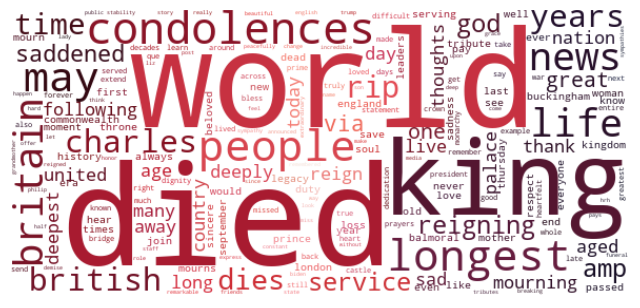

In [29]:
visualize_wordcloud(df=df_like_0, threshold=200, color='red', filename='like_0')

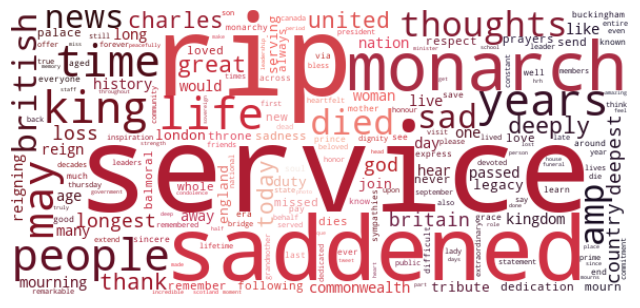

In [30]:
visualize_wordcloud(df=df_like_1to10, threshold=200, color='red', filename='like_1to10')

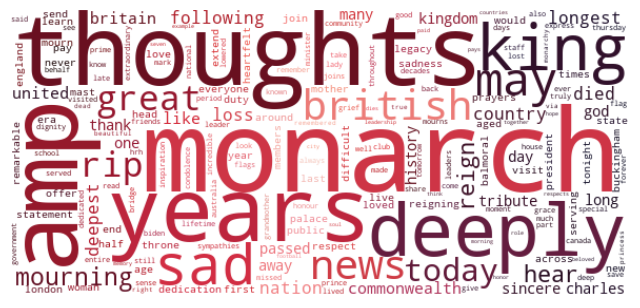

In [31]:
visualize_wordcloud(df=df_like_11to50, threshold=200, color='red', filename='like_11to50')

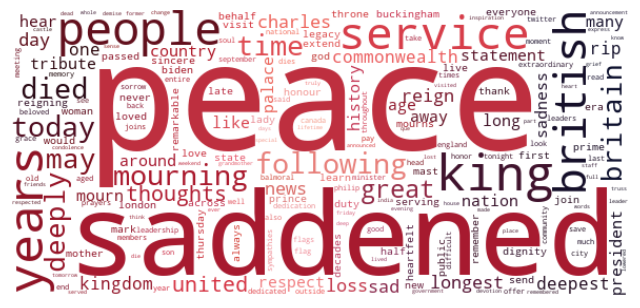

In [32]:
visualize_wordcloud(df=df_like_51to100, threshold=200, color='red', filename='like_51to100')

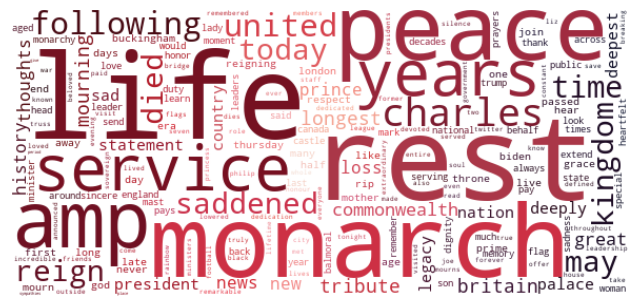

In [33]:
visualize_wordcloud(df=df_like_over100, threshold=200, color='red', filename='like_over100')

### 트윗 답글순 시각화: 감성 분석

In [34]:
rt_path = './condition/retweets_count/queen_'

df_rt_0       = pd.read_csv(rt_path+'rt_0.csv', lineterminator='\n', encoding='utf-8-sig')
df_rt_1to10   = pd.read_csv(rt_path+'rt_1to10.csv', lineterminator='\n', encoding='utf-8-sig')
df_rt_11to50  = pd.read_csv(rt_path+'rt_11to50.csv', lineterminator='\n', encoding='utf-8-sig')
df_rt_51to100 = pd.read_csv(rt_path+'rt_51to100.csv', lineterminator='\n', encoding='utf-8-sig')
df_rt_over100 = pd.read_csv(rt_path+'rt_over100.csv', lineterminator='\n', encoding='utf-8-sig')

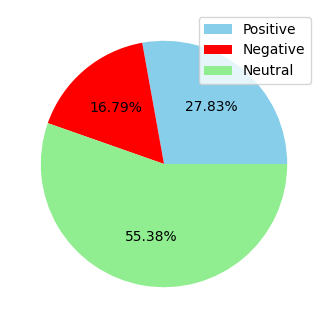

In [35]:
visualize_sentiment_analysis(df=df_rt_0, n=5, filename='rt_0')

In [36]:
df = pd.read_csv('./visualization/queen_sa_df_rt_0.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  Thank you so much for honoring Queen Elizabeth...  0.989397   
1  Goodnight, friends. Today's passing of Queen E...  0.988235   
2  Great effort to get this out tonight &amp; a r...  0.985739   
3  Eternal gratitude for your tremendous service&...  0.982499   
4  Pretty incredible and historic moment for Brit...  0.980672   

                                         부정 상위 5개 트윗     부정 점수  \
0  Finally dead! After 70 years of enjoying a lif...  0.969813   
1  If my dad tries to pull some shit on my mom an...  0.966844   
2  RIP Queen Elizabeth II  I’m scared for what’s ...  0.961994   
3  The death of  is not a reason for you to post ...  0.961345   
4  People who starts making jokes about Queen Eli...  0.957020   

                                         중립 상위 5개 트윗     중립 점수  
0  Elizabeth II with  at a state banquet at  Pala...  0.932211  
1  Charles will succeed Queen Elizabeth II: Royal...  0.926936  
2  Clionae and Jellusa has come to Pray the Funer...  0.922783  
3  Following the death of Queen Elizabeth II, Pri...  0.921517  
4  Alguien se dio cuenta q Will y Kate son los nu...  0.914466

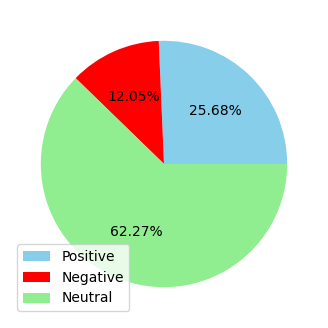

In [37]:
visualize_sentiment_analysis(df=df_rt_1to10, n=5, filename='rt_1to10')

In [38]:
df = pd.read_csv('./visualization/queen_sa_df_rt_1to10.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  This  programme celebrating 's visit is one of...  0.980713   
1  ❤️👑❤️ Hope shines, and her name is Queen Eliza...  0.978112   
2  RIP  I know everyone is wearing black on telly...  0.977850   
3  Her Majesty, Queen Elizabeth II, I’ve loved &a...  0.975037   
4  My precious certificate is above my desk and I...  0.972903   

                                         부정 상위 5개 트윗     부정 점수  \
0  After 20 minutes of laughing and waving this c...  0.967853   
1  Who cares if black babies sieged, bombed and s...  0.962628   
2  Why would you use the passing of an old lady; ...  0.961190   
3  As an Irish citizen, I have absolutely zero re...  0.956821   
4  Whoa. He arrived after she passed. He was late...  0.951833   

                                         중립 상위 5개 트윗     중립 점수  
0  Queen Elizabeth II Ethereum NFT Tribute Projec...  0.939987  
1  Queen Elizabeth II during her visit to Aden. 2...  0.935377  
2  Queen Elizabeth's son Charles will rule under ...  0.931818  
3  Following the passing of HM Queen Elizabeth II...  0.930960  
4  Queen Elizabeth II and Prime Minister Liz Trus...  0.928921

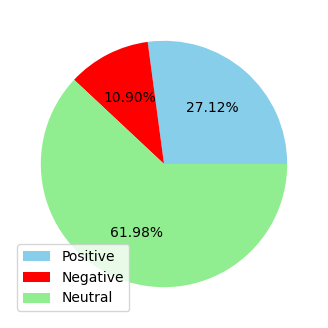

In [39]:
visualize_sentiment_analysis(df=df_rt_11to50, n=5, filename='rt_11to50')

In [40]:
df = pd.read_csv('./visualization/queen_sa_df_rt_11to50.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  This is glorious. What a woman she was.  Queen...  0.986893   
1  We are privileged to have hosted our Patron, H...  0.986281   
2  Here are tomorrow papers, what a wonderful tri...  0.982545   
3  Beautiful: Tel Aviv City Hall is lit up with t...  0.981010   
4  Thank you HM Queen Elizabeth II for a lifetime...  0.980799   

                                         부정 상위 5개 트윗     부정 점수  \
0  I know that I'm supposed to be on hiatus from ...  0.976606   
1  Queen Elizabeth II despised Trump.  His rude, ...  0.968527   
2  I think its safe to say that today has been th...  0.965283   
3  Just heard a stupid analyst on cable news say ...  0.959568   
4  lied to the    partied while Prince Philip die...  0.950498   

                                         중립 상위 5개 트윗     중립 점수  
0  Queen Elizabeth II meets Saudi King Khalid upo...  0.955068  
1  Which musician in Ghana do u think will do a s...  0.954906  
2  Queen Elizabeth II live updates: King Charles ...  0.944620  
3  Friday 9th September 2022  UK national front p...  0.942946  
4  Statement from The Governor-General on Her Maj...  0.941661

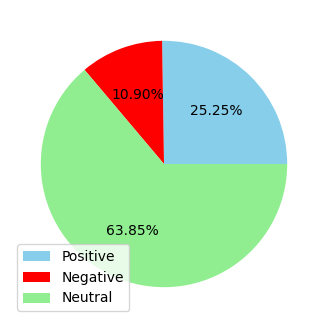

In [41]:
visualize_sentiment_analysis(df=df_rt_51to100, n=5, filename='rt_51to100')

In [42]:
df = pd.read_csv('./visualization/queen_sa_df_rt_51to100.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  Strength. Leadership. Principles. Duty. A rema...  0.980947   
1  One on my favourite pictures of an amazing cou...  0.977870   
2  Queen Elizabeth II  👑🕊️  Thank you for everyth...  0.977869   
3  I was so proud to perform for Queen Elizabeth ...  0.977070   
4  Queen Elizabeth II with the current  &amp;  Th...  0.971291   

                                         부정 상위 5개 트윗     부정 점수  \
0  You don't twerk at someone's funeral. Let alon...  0.968332   
1  Unbelievable and so embarrassed at the UK PM  ...  0.959660   
2  It's been over an hour and still no statement ...  0.949142   
3  there's a story on the front page of the BBC n...  0.940966   
4  Queen Elizabeth II forced native children into...  0.937954   

                                         중립 상위 5개 트윗     중립 점수  
0  PBBM STATEMENT ON THE PASSING OF QUEEN ELIZABE...  0.945877  
1  Queen Elizabeth II met with former Japanese Pr...  0.942378  
2  PM Lal Bahadur Shastri With Queen Elizabeth II...  0.936790  
3  Queen Elizabeth II walks with Nigeria's Presid...  0.936523  
4  Some photos of Queen Elizabeth II and some pas...  0.932506

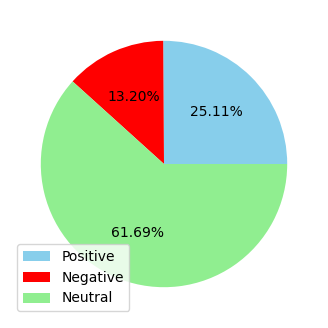

In [43]:
visualize_sentiment_analysis(df=df_rt_over100, n=5, filename='rt_over100')

In [44]:
df = pd.read_csv('./visualization/queen_sa_df_rt_over100.csv', encoding='utf-8-sig')
df.head(10)

긍정 상위 5개 트윗     긍정 점수  \
0  Hands down, this is one of the best stories ab...  0.987912   
1  You can never get tired of hearing this story ...  0.986230   
2  Today we celebrate the life of Queen Elizabeth...  0.984538   
3  "Midnights might be the best album ever made. ...  0.978023   
4  Her Majesty Queen Elizabeth II's influence rea...  0.976932   

                                         부정 상위 5개 트윗     부정 점수  \
0  FUCK YOU QUEEN ELIZABETH II, THIS IS WHAT I TH...  0.976610   
1  Queen Elizabeth II is dead and guess who is up...  0.948381   
2  BREAKING: Queen Elizabeth II is dead. She over...  0.944891   
3  Not my fellow Africans forgetting Lizbet’s inv...  0.930958   
4  As an African &amp; descendant of Mau Mau I ca...  0.930208   

                                         중립 상위 5개 트윗     중립 점수  
0  1961 :: Queen Elizabeth II Addressing Mammoth ...  0.948466  
1  We take a look back at Queen Elizabeth II's lo...  0.933753  
2  Kamal Haasan, Sarika, Nassar and Om Puri with ...  0.930733  
3  This is The New York Times front page from Feb...  0.929437  
4  Queen Elizabeth II was born to the Duke and Du...  0.928834

### 트윗 답글순 시각화: 워드클라우드

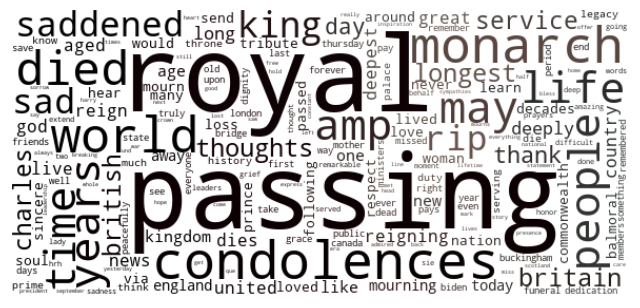

In [45]:
visualize_wordcloud(df=df_rt_0, threshold=100, color='brown', filename='rt_0')

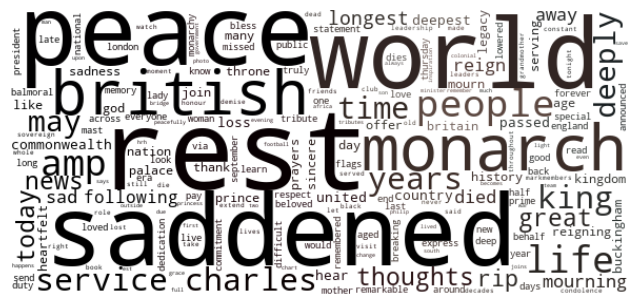

In [46]:
visualize_wordcloud(df=df_rt_1to10, threshold=100, color='brown', filename='rt_1to10')

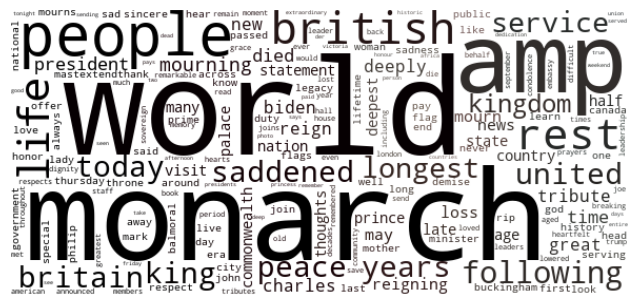

In [47]:
visualize_wordcloud(df=df_rt_11to50, threshold=100, color='brown', filename='rt_11to50')

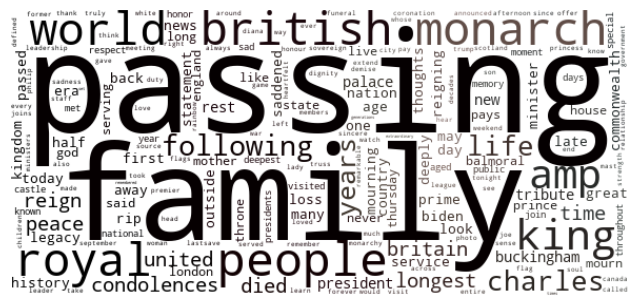

In [48]:
visualize_wordcloud(df=df_rt_51to100, threshold=100, color='brown', filename='rt_51to100')

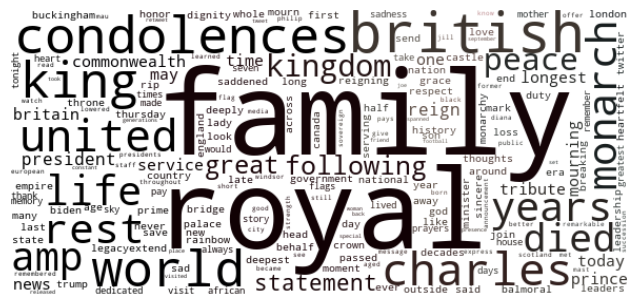

In [49]:
visualize_wordcloud(df=df_rt_over100, threshold=100, color='brown', filename='rt_over100')